In [1]:
from jax import numpy as np
from jax import jit, vmap
from numpy import random
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import seaborn as sns
sns.set_style('darkgrid')
sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

In [3]:
from scipy.special import erfinv

def Pinv(z,mu,sigma):
    return mu + np.sqrt(2)*sigma*erfinv(2*z-1)

def sigmoid(x):
    return 1/(1+np.exp(-x))

# Projected gradient descent

In [5]:
def clip_w(w,X,y):
    std = np.sqrt(np.mean(w**2))
    w_match = w_desired[np.argsort(np.argsort(w))]*std
    w = w_match

    losses = []
    for i in range(n_avg):
        yhat = w[i]@X[i] > 0
        loss = np.mean(y[i]!=yhat)
        losses.append(loss)
    losses = np.stack(losses)
    
    return np.mean(losses>0)

In [64]:
eta = 5e-2
eta2 = 1
N = 500
P = 100


def define_algorithm(eta,eta2,N,P):
    ''' Use this wrapper to re-define jitted functions '''
    def update_w(w,X,y):
        yhat = sigmoid(w@X)
        loss = np.mean(y!=(yhat>0.5))

        # Apply gradients
        grads = X@(y-yhat)
        w += eta*grads

        # Project onto feasible set
        std = np.sqrt(np.mean(w**2))
        w_match = w_desired[np.argsort(np.argsort(w))]

        w = w*(1-eta2) + eta2*w_match*std
        W2 = np.sqrt(((w/std-w_match)**2).mean()/2)

        return w, loss, W2


    def batched_update_w(w,X,y):
        return vmap(update_w)(w,X,y)


    def swap_idx(w):
        idx = random.randint(0,N)
        wsort = np.sort(w)
        wtmp = np.concatenate([wsort[:,:idx],wsort[:,np.arange(idx+1,idx-1,-1)],wsort[:,idx+2:]],axis=-1)
        wnew = wtmp[:,np.argsort(np.argsort(w)).squeeze()]
        return wnew


    def optimize_w(T,N):
        X = random.randn(n_avg,N,P)
        y = random.choice((0,1),(n_avg,P))
        w = np.zeros((n_avg, N))

        losses = []
        W2s = []
        for i in tqdm(range(T),leave=False):
            w, loss, W2 = batched_update_w(w,X,y)
            losses.append(loss)
            W2s.append(W2)

    #         if i % 100 ==0:
    #             w = swap_idx(w)
        losses = np.stack(losses)
        W2s = np.stack(W2s)

        return w,X,y,losses,W2s
    
    
define_algorithm(eta, eta2, N, P)

In [65]:
N = 500
T = 10000
n_avg = 100

mean = 0.95
sigma = np.sqrt(1-mean**2)
z = np.linspace(1,N,N,endpoint=False)/N
w_desired = Pinv(z,mean,sigma)
    
pred = 2*(1-mean**2)
P = int(pred*N)

w,X,y,losses,W2s = optimize_w(T,N)

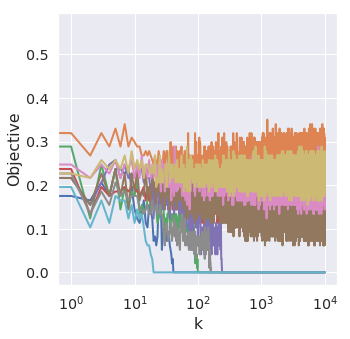

In [82]:
plt.figure(figsize=(5,5))
plt.plot(losses[:,::10], linewidth=2)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('k')
plt.ylabel('Objective');

In [68]:
(losses[-1]==0).mean()

DeviceArray(0.34, dtype=float32)

## Vary learning rate

In [61]:
N = 500
T = 1000
n_avg = 200

mean = 0.95
sigma = np.sqrt(1-mean**2)
z = np.linspace(1,N,N,endpoint=False)/N
w_desired = Pinv(z,mean,sigma)
pred = 2*(1-mean**2)
P = int(pred*N)

final_losses = []
etas = np.logspace(-2.5,-0.5,5)
for eta in tqdm(etas):
    define_algorithm(eta, eta2, N, P)
    w,X,y,losses,W2s = optimize_w(T,N)
    final_losses.append(losses[-1])
final_losses = np.stack(final_losses)

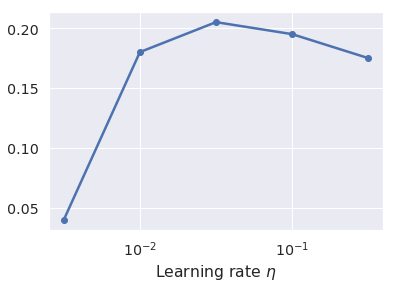

In [89]:
plt.plot(etas, (final_losses==0).mean(-1), 'o-')
plt.xscale('log')
plt.xlabel('Learning rate $\eta$');

# Alternating minimization

In [107]:
from jax import numpy as np

In [178]:
eta = 5e-2
eta2 = 0.7

def update_w(w,X,y):
    yhat = sigmoid(w@X)
    loss = np.mean(y!=(yhat>0.5))

    # Apply gradients
    grads = X@(y-yhat)
    w += eta*grads

    # Project onto feasible set
    std = np.sqrt(np.mean(w**2))
    w_match = w_desired[np.argsort(np.argsort(w))]

    w = w*(1-eta2) + eta2*w_match*std
    W2 = np.sqrt(((w/std-w_match)**2).mean()/2)

    return w, loss, W2


def batched_update_w(w,X,y):
    return vmap(update_w)(w,X,y)


def swap_idx(w, idx):
    wsort = np.sort(w)
    wtmp = np.concatenate([wsort[:,:idx],wsort[:,np.arange(idx+1,idx-1,-1)],wsort[:,idx+2:]],axis=-1)
    wnew = wtmp[:,np.argsort(np.argsort(w)).squeeze()]
    return wnew


def iterated_local_search(w,X,y,best_loss):
    for i in tqdm(range(N-1), leave=False):
        w2 = swap_idx(w,i)
        yhat = sigmoid(w2@X)
        loss = np.mean(y!=(yhat>0.5))
        if loss < best_loss:
            print('Found a better permutation!')
            return w2
    return w
    
    
def optimize_w(T,N,P):
    X = random.randn(n_avg,N,P)
    y = random.choice((0,1),(n_avg,P))
    w = np.zeros((n_avg, N))

    losses = []
    W2s = []
    for i in tqdm(range(T),leave=False):
        w, loss, W2 = batched_update_w(w,X,y)
        losses.append(loss)
        W2s.append(W2)
    losses = np.stack(losses)
    W2s = np.stack(W2s)

    return w,X,y,losses,W2s

0.35999998


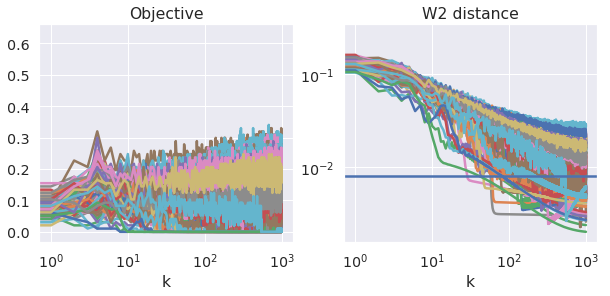

In [179]:
N = 500
T = 1000
n_avg = 100

mean = 0.95
sigma = np.sqrt(1-mean**2)
z = np.linspace(1,N,N,endpoint=False)/N
w_desired = Pinv(z,mean,sigma)
    
pred = 2*(1-mean**2)
P = int(pred*N)

w,X,y,losses,W2s = optimize_w(T,N,P)

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(losses)
plt.xlabel('k')
plt.xscale('log')
plt.title('Objective')

plt.subplot(122)
plt.plot(W2s);
plt.axhline(0.008)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('k')
plt.title('W2 distance')
print((losses[-1]==0).astype('int').mean())

Success rate = 0.36


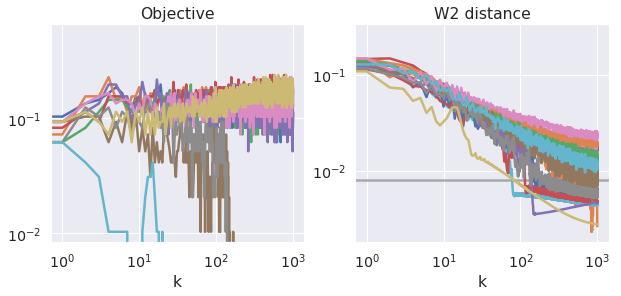

In [197]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(losses[:,::10])
plt.xlabel('k')
plt.xscale('log')
plt.yscale('log')
plt.title('Objective')

plt.subplot(122)
plt.plot(W2s[:,::5]);
plt.axhline(0.008, c='darkgrey', zorder=1)
plt.yscale('log')
plt.xscale('log')
plt.xlabel('k')
plt.title('W2 distance')

success_rate = np.mean((losses[-1]==0).astype('int') * (W2s[-1] < 8e-3).astype('int'))
print('Success rate = ' + str(np.round(success_rate, 3)))

# Iterated local search

In [69]:
eta = 1e-2
eta2 = 1

def update_w(w,X,y):
    yhat = sigmoid(w@X)
    loss = np.mean(y!=(yhat>0.5))

    # Apply gradients
    grads = X@(y-yhat)
    w += eta*grads

    # Project onto feasible set
    std = np.sqrt(np.mean(w**2))
    w_match = w_desired[np.argsort(np.argsort(w))]

    w = w*(1-eta2) + eta2*w_match*std
    W2 = np.sqrt(((w/std-w_match)**2).mean()/2)

    return w, loss, W2


def batched_update_w(w,X,y):
    return vmap(update_w)(w,X,y)


def swap_idx(w, idx):
    wsort = np.sort(w)
    wtmp = np.concatenate([wsort[:,:idx],wsort[:,np.arange(idx+1,idx-1,-1)],wsort[:,idx+2:]],axis=-1)
    wnew = wtmp[:,np.argsort(np.argsort(w)).squeeze()]
    return wnew


def iterated_local_search(w,X,y,best_loss):
    for i in tqdm(range(N-1), leave=False):
        w2 = swap_idx(w,i)
        yhat = sigmoid(w2@X)
        loss = np.mean(y!=(yhat>0.5))
        if loss < best_loss:
            print('Found a better permutation!')
            return w2
    return w
    
    
def optimize_w(T,N,P):
    X = random.randn(n_avg,N,P)
    y = random.choice((0,1),(n_avg,P))
    w = np.zeros((n_avg, N))

    losses = []
    W2s = []
    for i in tqdm(range(T),leave=False):
        w, loss, W2 = batched_update_w(w,X,y)
        losses.append(loss)
        W2s.append(W2)
        
        if (i+1) % 500 ==0:
            w = iterated_local_search(w,X,y,loss)
    losses = np.stack(losses)
    W2s = np.stack(W2s)

    return w,X,y,losses,W2s

In [70]:
from scipy.special import erfinv

def Pinv(z,mu,sigma):
    return mu + np.sqrt(2)*sigma*erfinv(2*z-1)

In [ ]:
N = 500
T = 3000
n_avg = 1

mean = 0.95
sigma = np.sqrt(1-mean**2)
z = np.linspace(1,N,N,endpoint=False)/N
w_desired = Pinv(z,mean,sigma)
    
pred = 2*(1-mean**2)
P = int(pred*N)

w,X,y,losses,W2s = optimize_w(T,N,P)
X = random.randn(n_avg,N,P)
y = random.choice((0,1),(n_avg,P))

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(losses)
plt.subplot(122)
plt.plot(W2s);
plt.yscale('log')

In [ ]:
loss_all = []
for i in range(50):
    w,X,y,losses,W2s = optimize_w(T,N,P)
    loss_all.append(losses)
loss_all = np.stack(loss_all).reshape(20,-1)

Text(0, 0.5, 'Objective')

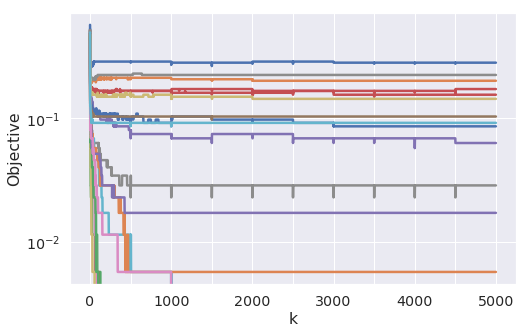

In [288]:
plt.figure(figsize=(8,5))
plt.plot(loss_all.T)
plt.yscale('log');
for i in range(T//500):
    plt.axvline(i*500, c='white', zorder=-99, linewidth=1)
plt.xlabel('k')
plt.ylabel('Objective')

In [278]:
(loss_all[:,-1] == 0).mean()

DeviceArray(0.35, dtype=float32)

# Method of multipliers

In [378]:
import numpy as np
import cvxpy as cp

In [383]:
def optimize_dual_decomp(N,P,w_desired):
    X = np.random.randn(N,P)
    y = np.random.choice((-1,1),(P))
    v = np.zeros(N)
    x = np.zeros(N)

    rho = 0.5

    diffs = []
    gs = []
    upper_bounds = []
    W2s = []
    for i in range(50):
        w = cp.Variable(N)
        w0 = w_desired[np.argsort(np.argsort(x))]

        prob = cp.Problem(
                cp.Minimize(cp.sum(cp.pos(-cp.multiply(y,(w@X)))) + v@(w0-w) + rho/2*cp.norm2(w0-w)**2),
                [cp.norm2(w)<=np.sqrt(N)]
            )
        g1 = prob.solve()
        gs.append(g1)
        x = w.value

        v += rho*(w0 - x)

        W2s.append(np.sqrt(np.mean((w0-x)**2)/2))

        upper_bounds.append(np.sum((-y*(x@X) > 0 )))
        
    return W2s, upper_bounds, x, X,y

In [384]:
mean = 0.95
sigma = np.sqrt(1-mean**2)
z = np.linspace(1,N,N,endpoint=False)/N
w_desired = Pinv(z,mean,sigma)
    
pred = 2*(1-mean**2)
P = int(pred*N)

W2s_all = []
upper_bounds_all = []
for i in tqdm(range(1000)):
    W2s, upper_bounds, x, X, y = optimize_dual_decomp(N,P,w_desired)
    W2s_all.append(W2s)
    upper_bounds_all.append(upper_bounds)
W2s_all = np.stack(W2s_all)
upper_bounds_all = np.stack(upper_bounds_all)

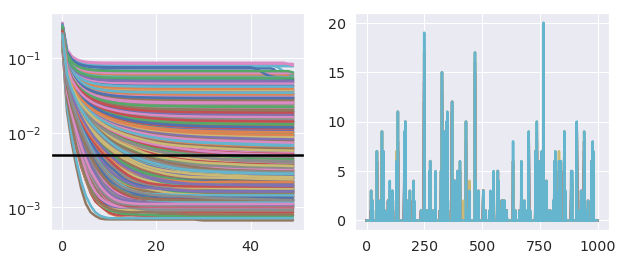

In [385]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(W2s_all.T)
# plt.title(W2s[-1])
plt.yscale('log')
plt.axhline(0.005, c='black')

plt.subplot(122)
plt.plot(upper_bounds_all);

In [390]:
(W2s_all[:,-1] < 0.006).mean()

0.491

In [391]:
np.save('data/method_multipliers_w2dists.npy', W2s_all)

In [205]:
W2s_all = np.load('data/method_multipliers_w2dists.npy')

In [207]:
W2s_all.shape

(1000, 50)

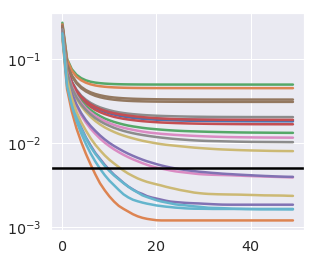

In [211]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(W2s_all[::50].T)
# plt.title(W2s[-1])
plt.yscale('log')
plt.axhline(0.005, c='black')

# plt.subplot(122)
# plt.plot(upper_bounds_all);

# ADMM

In [198]:
import numpy as np
import cvxpy as cp

In [199]:
N = 500

mean = 0.95
sigma = np.sqrt(1-mean**2)
z = np.linspace(1,N,N,endpoint=False)/N
w_desired = Pinv(z,mean,sigma)

pred = 2*(1 - mean**2)
P = int(pred*N)

X = np.random.randn(N,P)
y = np.random.choice((-1,1),(P))

In [200]:
rho = 1e-1

def ADMM(rho, P):
    X = np.random.randn(N,P)
    y = np.random.choice((-1,1),(P))
    uk = np.zeros(N)
    wk = np.random.randn(N)


    diffs = []
    objs = []
    zerr = []
    werr = []
    W2s = []
    for i in range(50):
        w = cp.Variable(N)

        prob = cp.Problem(
                cp.Minimize(cp.sum(cp.pos(-cp.multiply(y,(w@X)))) + rho/2*cp.norm2(w-wk+uk)**2),
                [cp.norm2(w)<=np.sqrt(N)]
            )
        obj = prob.solve()
        objs.append(obj)

        # Update z
        zk = w.value

        # Project onto feasible set
        wk = w_desired[np.argsort(np.argsort(zk+uk))]

        # Update dual variable
        uk += zk - wk

        # Error
        std = np.sqrt(np.mean(zk**2))
        W2s.append(np.sqrt(np.mean((zk/std-w_desired[np.argsort(np.argsort(zk))])**2)/2))

        zerr.append(np.sum((-y*(zk@X) > 0 )))
        werr.append(np.sum((-y*(wk@X) > 0 )))
        
    return W2s, zerr, werr

In [201]:
err_all = []
zerr_all = []
werr_all = []
for i in tqdm(range(100)):
    error, zerr, werr = ADMM(rho, P)
    err_all.append(error)
    zerr_all.append(zerr)
    werr_all.append(werr)
err_all = np.stack(err_all)
zerr_all = np.stack(zerr_all)
werr_all = np.stack(werr_all)

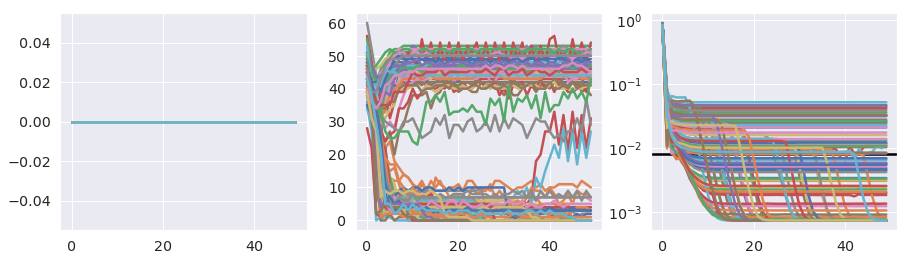

In [204]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.plot(zerr_all.T)
plt.subplot(132)
plt.plot(werr_all.T)
plt.subplot(133)
plt.plot(err_all.T)
plt.yscale('log')
plt.axhline(0.008, c='black', zorder=1)

In [418]:
(err_all[:,-1]<0.006).mean()

0.56

## ADMM capacity

In [448]:
alphas = np.linspace(0.1,0.3,10)
n_avg = 100

err_all = []
zerr_all = []
werr_all = []
for alpha in tqdm(alphas):
    P = int(alpha*N)
    for i in range(n_avg):
        error, zerr, werr = ADMM(rho, P)
        err_all.append(error)
        zerr_all.append(zerr)
        werr_all.append(werr)
err_all = np.stack(err_all).reshape(len(alphas),n_avg,-1)
zerr_all = np.stack(zerr_all).reshape(len(alphas),n_avg,-1)
werr_all = np.stack(werr_all).reshape(len(alphas),n_avg,-1)

In [507]:
errplot = (err_all[:,:,-1]<0.005).mean(-1)
apre = np.flip(np.arange(alphas[0],0,-np.diff(alphas)[0])[1:])
apost = np.arange(alphas[-1],0.4,np.diff(alphas)[0])[1:]
alpha_plot = np.concatenate([apre, alphas, apost])
errplot = np.concatenate([np.ones(len(apre)), errplot, np.zeros(len(apost))])

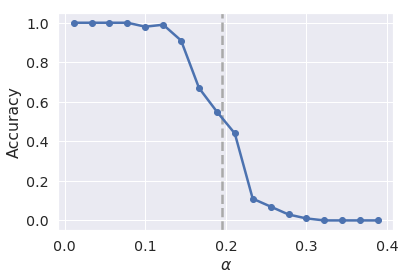

In [508]:
plt.plot(alpha_plot, errplot, 'o-')
plt.axvline(pred, c='darkgrey', linestyle='dashed', zorder=1)
plt.xlabel(r'$\alpha$')
plt.ylabel('Accuracy');

# Mixed integer programming

In [ ]:
N = 40

mean = 0.95
sigma = np.sqrt(1-mean**2)
z = np.linspace(1,N,N,endpoint=False)/N
w_desired = Pinv(z,mean,sigma)

pred = 2*(1 - mean**2)
P = int(pred*N)

In [ ]:
def solve_prob_cvx(alpha):
    P = int(alpha*N)
    # Setup problem
    X = np.random.randn(N,P)
    y = np.random.choice((-1,1),(P))
    A = cp.Variable((N,N), integer=True)
    w = A@w_desired
    yhat = w@X

    obj = cp.sum(cp.pos(-cp.multiply(y,yhat)))

    c1 = cp.sum(A,axis=0) == 1
    c2 = cp.sum(A,axis=1) == 1
    c3 = 0 <= A
    c4 = A <= 1

    prob = cp.Problem(
            cp.Minimize(obj),
            [c1,c2,c3,c4]
        )
    
    obj = prob.solve()
    return obj

In [ ]:
objs = []
alpha = pred
n_avg = 100
for i in tqdm(range(n_avg),leave=False):
    obj = solve_prob_cvx(alpha)
    if obj:
        objs.append(obj)
    else:
        objs.append(1)
objs = np.stack(objs)

In [ ]:
(objs<1e-5).mean()